# Web-Scraping and Cloud SQL 

*Emmanuel Molefi, 2023*

The notebook provides code to explore web-scraping and persisting data to Cloud SQL (https://cloud.google.com/sql), a cloud-based database by Google Cloud (https://cloud.google.com). The code is deliberately trivial in order to focus only on the core procedures that would be key to establishing a connection to the cloud database and persisting data then fetching the data back again. 

In [1]:
# [start]
import os
import sqlalchemy


def connect_unix_socket() -> sqlalchemy.engine.base.Engine:
    """ Initializes connection pool for a Cloud SQL instance of Postgres. """
    db_user = os.environ["DB_USER"] 
    db_pass = os.environ["DB_PASS"] 
    db_name = os.environ["DB_NAME"] 
    db_port = os.environ["DB_PORT"]

    pool = sqlalchemy.create_engine(
        sqlalchemy.engine.url.URL.create(
            drivername="postgresql+pg8000",
            username=db_user,
            password=db_pass,
            port=db_port,
            database=db_name,
        ),
        pool_size=5,
        max_overflow=2,
        pool_timeout=30,  # 30 seconds
        pool_recycle=1800,  # 30 minutes
    )
    return pool


def init_connection_pool() -> sqlalchemy.engine.base.Engine:
    return connect_unix_socket()

# [end]

In [2]:
# [start]

# product details
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.common.by import By


def get_product_info(product_url):
    chrome_options = ChromeOptions()
    chrome_options.add_argument("--headless")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get(product_url)

    product_title = driver.find_element(By.CLASS_NAME, "product-title").text
    product_desc = driver.find_element(By.CLASS_NAME, "product-description").text  
    nutritionals = driver.find_elements(By.CLASS_NAME, "nutrition-information-nutritional")

    info = {
        "product_title": product_title,
        "product_desc": product_desc,
    }

    for nutritional in nutritionals:
        nlabel = nutritional.find_element(By.CLASS_NAME, "copy-02").text
        nvalue = nutritional.find_element(By.CLASS_NAME, "nutritional-value").text
        info[nlabel] = nvalue

    driver.quit()

    return info

# [end]

In [3]:
# [start]

# drinks
from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.common.by import By


def get_drink_data(drink_url):
    chrome_options = ChromeOptions()
    chrome_options.add_argument("--headless")

    driver = webdriver.Chrome(options=chrome_options)
    driver.get(drink_url) # e.g., '/drinks/brewed-coffee'

    drink_data = []

    drink_type = drink_url.split("/")[-1]
    

    products_list = driver.find_elements(By.CLASS_NAME, "products-list")
    print(f"There are [{len(products_list)}] different [{drink_type}].")

    for p in products_list:
        product_dict_tmp = {"drink_type": drink_type}
        
        menu_group_title = p.find_element(By.CLASS_NAME, "menu-group-title").text
        product_dict_tmp["product_group_title"] = menu_group_title 

        menu_item_titles = p.find_elements(By.CLASS_NAME, "menu-item-title")
        print(f"There are [{len(menu_item_titles)}] different [{drink_type}][{menu_group_title}].")

        products_urls = p.find_elements(By.CLASS_NAME, "menu-item")
        for i in range(len(products_urls)):
            product_item_url = products_urls[i].get_attribute("href")
            print(product_item_url)
            product_id = product_item_url.split("/")[-1]
            prod_dict_tmp = {"product_id": product_id}
            prod_dict_tmp.update(product_dict_tmp)
            
            product_info = get_product_info(product_item_url) 

            dc = prod_dict_tmp.copy()
            dc.update(product_info) 
            drink_data.append(dict(dc))
            
    return drink_data

# [end]

In [4]:
# [start]

# web-scraping using "selenium"
import pandas as pd

from IPython.display import display

from selenium import webdriver
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.common.by import By


chrome_options = ChromeOptions()
chrome_options.add_argument("--headless")

driver = webdriver.Chrome(options=chrome_options)

frames = []

driver.get('https://www.starbucks.co.uk/menu/drinks') # base
drink_links = driver.find_elements(By.CLASS_NAME, "menu-item")
print(f"There are [{len(drink_links)}] different drinks available.")

for d in drink_links:
    drink_url = d.get_attribute("href")
    print( drink_url )
    drink_data = get_drink_data(drink_url)

    df = pd.DataFrame(drink_data) 
    frames.append(df) 

result = pd.concat(frames)
display(result)
# 
driver.quit()
# [end]

There are [9] different drinks available.
https://www.starbucks.co.uk/menu/drinks/espresso-drinks
There are [8] different [espresso-drinks].
There are [2] different [espresso-drinks][Latte].
https://www.starbucks.co.uk/menu/product/2369
https://www.starbucks.co.uk/menu/product/1707
There are [4] different [espresso-drinks][Mocha].
https://www.starbucks.co.uk/menu/product/2591
https://www.starbucks.co.uk/menu/product/1635
https://www.starbucks.co.uk/menu/product/925
https://www.starbucks.co.uk/menu/product/2857
There are [3] different [espresso-drinks][Macchiato].
https://www.starbucks.co.uk/menu/product/37
https://www.starbucks.co.uk/menu/product/2915
https://www.starbucks.co.uk/menu/product/95
There are [3] different [espresso-drinks][Cappuccino].
https://www.starbucks.co.uk/menu/product/453
https://www.starbucks.co.uk/menu/product/2503
https://www.starbucks.co.uk/menu/product/75
There are [2] different [espresso-drinks][Americano].
https://www.starbucks.co.uk/menu/product/2259
https:

,product_id,drink_type,product_group_title,product_title,product_desc,Serving size,Energy,Fat,Saturated fat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,2369,espresso-drinks,Latte,Caffè Latte,"Our dark, rich espresso is balanced with steam...",Short,343 KJ/82 Kcal *,2.8g,2.7g,8g,7.6g,0.1g,6g,0.2g,33.1mg **
1,1707,espresso-drinks,Latte,Iced Caffè Latte,"Our dark, rich espresso is combined with milk ...",Tall,412 KJ/98 Kcal *,3.3g,3.1g,9.6g,8.7g,0.2g,7.3g,0.25g,66.2mg **
2,2591,espresso-drinks,Mocha,Caffè Mocha,Espresso with bittersweet mocha sauce and stea...,Short,686 KJ/164 Kcal *,7.9g,5.9g,16.6g,15.5g,1.5g,5.9g,0.14g,33.1mg **
3,1635,espresso-drinks,Mocha,Iced Caffè Mocha,"We combine our rich, full-bodied espresso with...",Tall,1153 KJ/275 Kcal *,13g,10g,27.6g,25.7g,2.3g,10.8g,0.28g,66.2mg **
4,925,espresso-drinks,Mocha,White Chocolate Mocha,Espresso with white chocolate flavoured sauce ...,Short,861 KJ/206 Kcal *,9.3g,7.3g,24.5g,24.1g,0.1g,5.9g,0.25g,33.1mg **
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,8327,bottled-drinks,Shots,Turmeric Shot 100ml,A fiery blend of apple and turmeric with hot c...,100ml,176 KJ/42 Kcal *,0.4g,0g,8.9g,8.9g,0.4g,0.4g,0.01g,NaN
11,11219,bottled-drinks,Seltzers & Kombucha,DASH Water Sparkling Cucumber 330ml,Sparkling Spring Water infused with wonky cucu...,330ml,13 KJ/3 Kcal *,0g,0g,0g,0g,0g,0g,0.001g,NaN
12,11287,bottled-drinks,Seltzers & Kombucha,DASH Water Sparkling Peach 330ml,Sparkling Spring Water infused with wonky peac...,330ml,28 KJ/7 Kcal *,0g,0g,1.65g,0g,0g,0g,0.01g,NaN
13,11235,bottled-drinks,Seltzers & Kombucha,Remedy Cherry Plum Kombucha 250ml,"Fruity and refreshing. It’s light, fizzy, and ...",250ml,99 KJ/24 Kcal *,0.5g,0.1g,4g,0g,0.5g,0.5g,0.01g,NaN


In [5]:
# [start]

# persist as csv
result.to_csv(path_or_buf="starbucks_drinks.csv",index=False)

# [end]

In [6]:
# [start]

# persist data to Cloud SQL (https://cloud.google.com/sql) 
def save_drink(db: sqlalchemy.engine.base.Engine, drink_data: dict):
    # Preparing a statement 
    stmt = sqlalchemy.text(
        "INSERT INTO drinks (productID, drinkType, productGroupTitle, productTitle, productDesc, servingSize, energy, fat, saturatedFat, carbohydrates, sugar, fibre, protein, salt, caffeine) VALUES (:productID, :drinkType, :productGroupTitle, :productTitle, :productDesc, :servingSize, :energy, :fat, :saturatedFat, :carbohydrates, :sugar, :fibre, :protein, :salt, :caffeine)"
    )
    try:
        # Persist
        with db.connect() as conn:
            conn.execute(stmt, parameters=drink_data) 
            conn.commit()
    except Exception as e:
        # Something went wrong, we may need to handle it here 
        return False 

    return True

# [end]

In [7]:
# [start]

df = pd.read_csv('starbucks_drinks.csv') # 
# display(df)
db = init_connection_pool()

for index, row in df.iterrows():
    d_data = {
        "productID": row['product_id'], 
        "drinkType": row['drink_type'], 
        "productGroupTitle": row['product_group_title'], 
        "productTitle": row['product_title'], 
        "productDesc": row['product_desc'], 
        "servingSize": row['Serving size'], 
        "energy": row['Energy'], 
        "fat": row['Fat'], 
        "saturatedFat": row['Saturated fat'], 
        "carbohydrates": row['Carbohydrates'], 
        "sugar": row['Sugar'], 
        "fibre": row['Fibre'], 
        "protein": row['Protein'], 
        "salt": row['Salt'], 
        "caffeine": row['Caffeine'],
    }
    response = save_drink(db=db, drink_data=d_data) 

# [end]

In [8]:
# [start]

from typing import Dict
import sqlalchemy


# read data to Cloud SQL (https://cloud.google.com/sql)
def get_drinks_from_db(db: sqlalchemy.engine.base.Engine) -> Dict:
    data = []

    with db.connect() as conn:
        drinks = conn.execute(sqlalchemy.text(
            "SELECT * FROM drinks"
        )).fetchall()

        for row in drinks:
            data.append({
                "productID": row[0], 
                "drinkType": row[1], 
                "productGroupTitle": row[2], 
                "productTitle": row[3], 
                "productDesc": row[4], 
                "servingSize": row[5], 
                "energy": row[6], 
                "fat": row[7], 
                "saturatedFat": row[8], 
                "carbohydrates": row[9], 
                "sugar": row[10], 
                "fibre": row[11], 
                "protein": row[12], 
                "salt": row[13], 
                "caffeine": row[14],
            })

    return {
        "drinksData": data,
    }

# [end]

In [9]:
# [start]

import pandas as pd


db = init_connection_pool() # 

drinksData = get_drinks_from_db(db) # 

dat_df = pd.DataFrame(drinksData["drinksData"])
display(dat_df)

# [end]

,productID,drinkType,productGroupTitle,productTitle,productDesc,servingSize,energy,fat,saturatedFat,carbohydrates,sugar,fibre,protein,salt,caffeine
0,2245,iced-coffee-cold-brew,Iced Coffee & Cold Brew,Cold Brew Coffee,Our Cold Brew coffee is handcrafted in small b...,Tall,68 KJ/16 Kcal *,1g,0.2g,0g,0g,1g,1.2g,0.26g,37mg **
1,5,iced-coffee-cold-brew,Iced Coffee & Cold Brew,Cold Brew Latte,Try our Cold Brew coffee just the way you like...,Tall,390 KJ/93 Kcal *,3.3g,2.9g,8.8g,7.9g,0.5g,6.6g,0.3g,38.7mg **
2,2179,iced-coffee-cold-brew,Iced Coffee & Cold Brew,Nitro Cold Brew,Starbucks Cold Brew coffee is infused with nit...,Tall,115 KJ/28 Kcal *,1.7g,0.3g,0g,0g,1.7g,2.1g,0.44g,63mg **
3,463,iced-coffee-cold-brew,Iced Coffee & Cold Brew,Nitro Latte,"Served cold, straight from the tap, our Nitro ...",Tall,493 KJ/117 Kcal *,1.6g,0.4g,18.4g,18.2g,1.2g,6.5g,0.46g,42.9mg **
4,175,iced-coffee-cold-brew,Iced Coffee & Cold Brew,Nitro Cappuccino,We are expanding our Nitro Cold Brew family! N...,Tall,193 KJ/46 Kcal *,1.4g,0.3g,3.6g,3.6g,1.2g,4.1g,0.38g,42.9mg **
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2789,espresso-drinks,Flat White and Cortado,Cortado,"Two ristretto shots topped with warm, silky mi...",Short,302 KJ/72 Kcal *,3.7g,2.2g,5.4g,4.6g,0.2g,4.2g,0.16g,66.2mg **
78,191661,espresso-drinks,Shaken Espresso,Iced Toasted Vanilla Oat Shaken Espresso,Using our subtly sweet Starbucks Blonde® Espre...,Tall,421 KJ/100 Kcal *,3.7g,0.4g,14.3g,9.4g,1.4g,1.7g,0.21g,56.7mg **
79,9497,espresso-drinks,Shaken Espresso,Iced Brown Sugar Oat Shaken Espresso,Using our subtly sweet Starbucks Blonde® Espre...,Tall,424 KJ/101 Kcal *,3.7g,0.4g,14.5g,9.7g,1.4g,1.7g,0.21g,56.7mg **
80,2151,brewed-coffee,Brewed Coffee,Filter Coffee,"Iconic Starbucks coffee that's smooth, balance...",Short,96 KJ/24 Kcal *,1.2g,0.2g,1g,0.2g,1.2g,1.4g,0.3g,70mg **


In [10]:
# [start]

df = pd.read_csv('starbucks_drinks.csv') # 

display(df)
# [end]

,product_id,drink_type,product_group_title,product_title,product_desc,Serving size,Energy,Fat,Saturated fat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,2369,espresso-drinks,Latte,Caffè Latte,"Our dark, rich espresso is balanced with steam...",Short,343 KJ/82 Kcal *,2.8g,2.7g,8g,7.6g,0.1g,6g,0.2g,33.1mg **
1,1707,espresso-drinks,Latte,Iced Caffè Latte,"Our dark, rich espresso is combined with milk ...",Tall,412 KJ/98 Kcal *,3.3g,3.1g,9.6g,8.7g,0.2g,7.3g,0.25g,66.2mg **
2,2591,espresso-drinks,Mocha,Caffè Mocha,Espresso with bittersweet mocha sauce and stea...,Short,686 KJ/164 Kcal *,7.9g,5.9g,16.6g,15.5g,1.5g,5.9g,0.14g,33.1mg **
3,1635,espresso-drinks,Mocha,Iced Caffè Mocha,"We combine our rich, full-bodied espresso with...",Tall,1153 KJ/275 Kcal *,13g,10g,27.6g,25.7g,2.3g,10.8g,0.28g,66.2mg **
4,925,espresso-drinks,Mocha,White Chocolate Mocha,Espresso with white chocolate flavoured sauce ...,Short,861 KJ/206 Kcal *,9.3g,7.3g,24.5g,24.1g,0.1g,5.9g,0.25g,33.1mg **
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,8327,bottled-drinks,Shots,Turmeric Shot 100ml,A fiery blend of apple and turmeric with hot c...,100ml,176 KJ/42 Kcal *,0.4g,0g,8.9g,8.9g,0.4g,0.4g,0.01g,NaN
78,11219,bottled-drinks,Seltzers & Kombucha,DASH Water Sparkling Cucumber 330ml,Sparkling Spring Water infused with wonky cucu...,330ml,13 KJ/3 Kcal *,0g,0g,0g,0g,0g,0g,0.001g,NaN
79,11287,bottled-drinks,Seltzers & Kombucha,DASH Water Sparkling Peach 330ml,Sparkling Spring Water infused with wonky peac...,330ml,28 KJ/7 Kcal *,0g,0g,1.65g,0g,0g,0g,0.01g,NaN
80,11235,bottled-drinks,Seltzers & Kombucha,Remedy Cherry Plum Kombucha 250ml,"Fruity and refreshing. It’s light, fizzy, and ...",250ml,99 KJ/24 Kcal *,0.5g,0.1g,4g,0g,0.5g,0.5g,0.01g,NaN


In [11]:
df.shape

(82, 15)

In [12]:
df.columns

Index(['product_id', 'drink_type', 'product_group_title', 'product_title',
       'product_desc', 'Serving size', 'Energy', 'Fat', 'Saturated fat',
       'Carbohydrates', 'Sugar', 'Fibre', 'Protein', 'Salt', 'Caffeine'],
      dtype='object')

In [13]:
df = df.rename(columns={
    'product_id': 'Product_ID', 
    'drink_type': 'DrinkType', 
    'product_group_title': 'ProductGroupTitle', 
    'product_title': 'ProductTitle',
    'product_desc': 'ProductDesc', 
    'Serving size': 'ServingSize', 
    'Saturated fat': 'SaturatedFat'
})

In [14]:
df_nutrition = df.loc[:, "Energy":"Caffeine"]

df_nutrition

,Energy,Fat,SaturatedFat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,343 KJ/82 Kcal *,2.8g,2.7g,8g,7.6g,0.1g,6g,0.2g,33.1mg **
1,412 KJ/98 Kcal *,3.3g,3.1g,9.6g,8.7g,0.2g,7.3g,0.25g,66.2mg **
2,686 KJ/164 Kcal *,7.9g,5.9g,16.6g,15.5g,1.5g,5.9g,0.14g,33.1mg **
3,1153 KJ/275 Kcal *,13g,10g,27.6g,25.7g,2.3g,10.8g,0.28g,66.2mg **
4,861 KJ/206 Kcal *,9.3g,7.3g,24.5g,24.1g,0.1g,5.9g,0.25g,33.1mg **
...,...,...,...,...,...,...,...,...,...
77,176 KJ/42 Kcal *,0.4g,0g,8.9g,8.9g,0.4g,0.4g,0.01g,NaN
78,13 KJ/3 Kcal *,0g,0g,0g,0g,0g,0g,0.001g,NaN
79,28 KJ/7 Kcal *,0g,0g,1.65g,0g,0g,0g,0.01g,NaN
80,99 KJ/24 Kcal *,0.5g,0.1g,4g,0g,0.5g,0.5g,0.01g,NaN


In [15]:
df_nutrition.isnull().sum()

Energy            0
Fat               0
SaturatedFat      0
Carbohydrates     0
Sugar             0
Fibre             0
Protein           0
Salt              0
Caffeine         15
dtype: int64

In [16]:
pd.set_option('display.max_rows', df_nutrition.shape[0] + 1)
display(df_nutrition)
pd.set_option('display.max_rows', 10)

,Energy,Fat,SaturatedFat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,343 KJ/82 Kcal *,2.8g,2.7g,8g,7.6g,0.1g,6g,0.2g,33.1mg **
1,412 KJ/98 Kcal *,3.3g,3.1g,9.6g,8.7g,0.2g,7.3g,0.25g,66.2mg **
2,686 KJ/164 Kcal *,7.9g,5.9g,16.6g,15.5g,1.5g,5.9g,0.14g,33.1mg **
3,1153 KJ/275 Kcal *,13g,10g,27.6g,25.7g,2.3g,10.8g,0.28g,66.2mg **
4,861 KJ/206 Kcal *,9.3g,7.3g,24.5g,24.1g,0.1g,5.9g,0.25g,33.1mg **
5,1410 KJ/336 Kcal *,15.1g,12g,39.3g,38.4g,0.2g,10.7g,0.45g,66.2mg **
6,343 KJ/82 Kcal *,2.8g,2.7g,8g,7.6g,0.1g,6g,0.2g,33.1mg **
7,468 KJ/111 Kcal *,3.4g,3g,14.8g,13.9g,0.1g,5.3g,0.21g,33.1mg **
8,652 KJ/155 Kcal *,4.3g,3.8g,21.4g,20.1g,0.2g,7.4g,0.28g,66.2mg **
9,274 KJ/65 Kcal *,2.2g,2.1g,6.4g,5.9g,0.1g,4.9g,0.16g,33.1mg **


In [17]:
df_nutrition = df_nutrition.fillna('0mg **')

df_nutrition

,Energy,Fat,SaturatedFat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,343 KJ/82 Kcal *,2.8g,2.7g,8g,7.6g,0.1g,6g,0.2g,33.1mg **
1,412 KJ/98 Kcal *,3.3g,3.1g,9.6g,8.7g,0.2g,7.3g,0.25g,66.2mg **
2,686 KJ/164 Kcal *,7.9g,5.9g,16.6g,15.5g,1.5g,5.9g,0.14g,33.1mg **
3,1153 KJ/275 Kcal *,13g,10g,27.6g,25.7g,2.3g,10.8g,0.28g,66.2mg **
4,861 KJ/206 Kcal *,9.3g,7.3g,24.5g,24.1g,0.1g,5.9g,0.25g,33.1mg **
...,...,...,...,...,...,...,...,...,...
77,176 KJ/42 Kcal *,0.4g,0g,8.9g,8.9g,0.4g,0.4g,0.01g,0mg **
78,13 KJ/3 Kcal *,0g,0g,0g,0g,0g,0g,0.001g,0mg **
79,28 KJ/7 Kcal *,0g,0g,1.65g,0g,0g,0g,0.01g,0mg **
80,99 KJ/24 Kcal *,0.5g,0.1g,4g,0g,0.5g,0.5g,0.01g,0mg **


In [18]:
df_nutrition.isnull().sum()

Energy           0
Fat              0
SaturatedFat     0
Carbohydrates    0
Sugar            0
Fibre            0
Protein          0
Salt             0
Caffeine         0
dtype: int64

In [19]:
df_nutrition['Energy'] = df_nutrition['Energy'].str.split(" KJ/").str[0] # these are now stripped of meaning; there is a better way

df_nutrition

,Energy,Fat,SaturatedFat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,343,2.8g,2.7g,8g,7.6g,0.1g,6g,0.2g,33.1mg **
1,412,3.3g,3.1g,9.6g,8.7g,0.2g,7.3g,0.25g,66.2mg **
2,686,7.9g,5.9g,16.6g,15.5g,1.5g,5.9g,0.14g,33.1mg **
3,1153,13g,10g,27.6g,25.7g,2.3g,10.8g,0.28g,66.2mg **
4,861,9.3g,7.3g,24.5g,24.1g,0.1g,5.9g,0.25g,33.1mg **
...,...,...,...,...,...,...,...,...,...
77,176,0.4g,0g,8.9g,8.9g,0.4g,0.4g,0.01g,0mg **
78,13,0g,0g,0g,0g,0g,0g,0.001g,0mg **
79,28,0g,0g,1.65g,0g,0g,0g,0.01g,0mg **
80,99,0.5g,0.1g,4g,0g,0.5g,0.5g,0.01g,0mg **


In [20]:
df_nutrition['Caffeine'] = df_nutrition['Caffeine'].str.split("mg").str[0]

df_nutrition = df_nutrition.replace(to_replace=r'g', value='', regex=True)

df_nutrition

,Energy,Fat,SaturatedFat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,343,2.8,2.7,8,7.6,0.1,6,0.2,33.1
1,412,3.3,3.1,9.6,8.7,0.2,7.3,0.25,66.2
2,686,7.9,5.9,16.6,15.5,1.5,5.9,0.14,33.1
3,1153,13,10,27.6,25.7,2.3,10.8,0.28,66.2
4,861,9.3,7.3,24.5,24.1,0.1,5.9,0.25,33.1
...,...,...,...,...,...,...,...,...,...
77,176,0.4,0,8.9,8.9,0.4,0.4,0.01,0
78,13,0,0,0,0,0,0,0.001,0
79,28,0,0,1.65,0,0,0,0.01,0
80,99,0.5,0.1,4,0,0.5,0.5,0.01,0


In [21]:
df_nutrition = df_nutrition.astype('float')
df_nutrition

,Energy,Fat,SaturatedFat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,343.0,2.8,2.7,8.00,7.6,0.1,6.0,0.200,33.1
1,412.0,3.3,3.1,9.60,8.7,0.2,7.3,0.250,66.2
2,686.0,7.9,5.9,16.60,15.5,1.5,5.9,0.140,33.1
3,1153.0,13.0,10.0,27.60,25.7,2.3,10.8,0.280,66.2
4,861.0,9.3,7.3,24.50,24.1,0.1,5.9,0.250,33.1
...,...,...,...,...,...,...,...,...,...
77,176.0,0.4,0.0,8.90,8.9,0.4,0.4,0.010,0.0
78,13.0,0.0,0.0,0.00,0.0,0.0,0.0,0.001,0.0
79,28.0,0.0,0.0,1.65,0.0,0.0,0.0,0.010,0.0
80,99.0,0.5,0.1,4.00,0.0,0.5,0.5,0.010,0.0


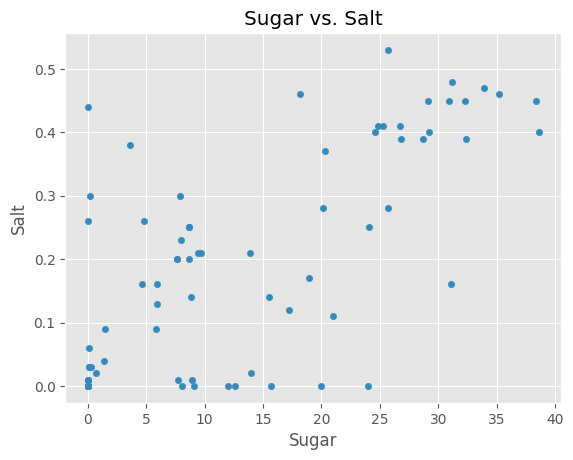

In [22]:
# 
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')


df_nutrition.plot(kind="scatter", x="Sugar", y="Salt", title="Sugar vs. Salt")
plt.show()

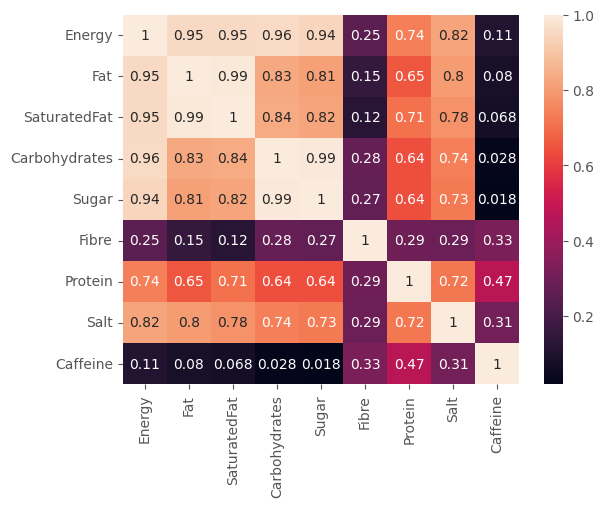

In [23]:
df_nutrition_corr = df_nutrition.corr()

sns.heatmap(df_nutrition_corr, annot=True)
plt.show()

,DrinkType,Energy,Fat,SaturatedFat,Carbohydrates,Sugar,Fibre,Protein,Salt,Caffeine
0,espresso-drinks,343.0,2.8,2.7,8.0,7.6,0.1,6.0,0.20,33.1
1,espresso-drinks,412.0,3.3,3.1,9.6,8.7,0.2,7.3,0.25,66.2


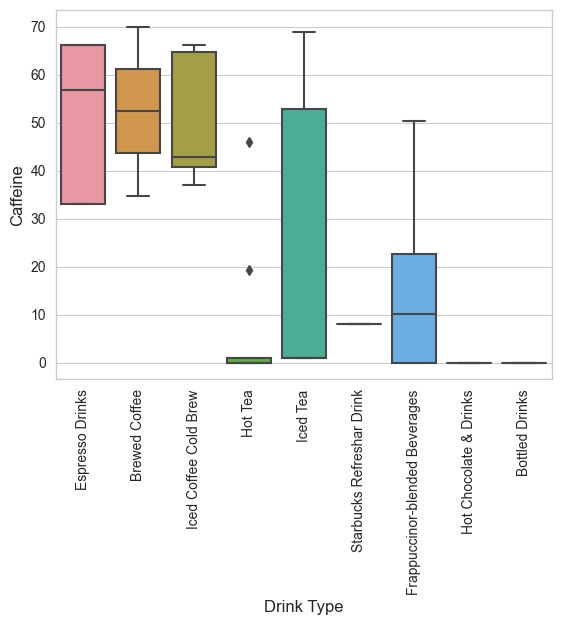

In [24]:
df_drinktype = pd.concat([df["DrinkType"], df_nutrition],axis=1)

display(df_drinktype.head(2))


sns.boxplot(data=df_drinktype, x="DrinkType", y="Caffeine")
plt.xticks(rotation=90, ticks=list(range(9)), labels=['Espresso Drinks', 'Brewed Coffee', 'Iced Coffee Cold Brew', 'Hot Tea', 'Iced Tea', 'Starbucks Refreshar Drink', 'Frappuccinor-blended Beverages', 'Hot Chocolate & Drinks', 'Bottled Drinks'])
plt.xlabel("Drink Type")
plt.show()